# Querry data based on ro-Crates

**Steps:** (for each metaGOflow step)
1. Acess ro-crate metadata file and extract needed data sources
2. Get the data
3. Visualize

In [1]:
import sys
import os
import logging
from IPython import get_ipython

logger = logging.getLogger(name="Quality Control app")

if 'google.colab' in str(get_ipython()):
    print('Setting Google colab, you will need a ngrok account to make the dashboard display over the tunnel. \
    https://ngrok.com/')
    # clone the momics-demos repository to use it to load data
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')

    # this step takes time beacause of many dependencies
    os.system('pip install marine-omics')

from momics.utils import (
    reconfig_logger, init_setup,
)

# Set up logging
reconfig_logger()
init_setup()

INFO | root | Logging.basicConfig completed successfully


## Imports

In [2]:
import requests
import html

from functools import partial
import panel as pn
from IPython.display import display, HTML, Markdown

# All low level functions are imported from the momics package
from momics.loader import (
    get_rocrate_metadata_gh,
    extract_data_by_name,
)

### Data

In [3]:
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')

## Dropdown and tabs

In [4]:
pn.extension("tabulator")
pn.extension('mathjax', 'plotly')
if 'google.colab' in str(get_ipython()):
    pn.extension(comms='colab')
    
archives = [
    "EMOBON_MBAL4_Wa_2",
    "EMOBON_NRMCB_So_1",
    "EMOBON_NRMCB_So_7",
    "EMOBON_OSD74_Wa_2",
    "EMOBON_PiEGetxo_Wa_4",
    "EMOBON_RFormosa_Wa_6",
    "EMOBON_ROSKOGO_So_1",
    "EMOBON_VB_Wa_93",
]
select_archive = pn.widgets.Select(
    name="Archive",
    options= archives,
    value=archives[0],
    description="Select an archive for inspection",
)

def concat_to_markdown(data: list) -> str:
    """
    Concatenate the data to a markdown string
    """
    return "\n".join([f"{item}\n" for item in data])


In [5]:
select_archive

BokehModel(combine_events=True, render_bundle={'docs_json': {'ab2187cb-3157-4a2b-a585-75e60c621b04': {'version…

In [6]:
metadata = get_rocrate_metadata_gh(select_archive.value)
data = extract_data_by_name(metadata, name='FASTP analysis of raw sequence data')
r = requests.get(data['downloadUrl'])
escaped_content = html.escape(r.content.decode('utf-8'))
iframe = f'<iframe srcdoc="{escaped_content}" style="height:1000px; width:900px;"></iframe>'
display(HTML(iframe))

ro-crate-metadata.json request status 200


/home/david-palecek/miniforge3/envs/momics-demos/lib/python3.13/site-packages/IPython/core/display.py:447: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [7]:
data = extract_data_by_name(metadata, name='MetaGOflow YAML configuration file')
r = requests.get(data['downloadUrl'])
print(r.content.decode('utf-8'))

assemble: true
base_correction: false
both_reads: [DBB_AAECOSDA_2_1_HVWGWDSX5.UDI182_clean, DBB_AAECOSDA_2_2_HVWGWDSX5.UDI182_clean]
cgc_chunk_size: 200
cgc_step: true
correction: false
count_faa_from_previous_run: null
cut_right: false
detect_adapter_for_pe: false
disable_trim_poly_g: null
force_polyg_tail_trimming: null
forward_reads: {class: File, format: 'edam:format_1930', path: /home/cymon/src/metaGOflow-cymon.git/input_data/DBB_AAECOSDA_2_1_HVWGWDSX5.UDI182_clean.fastq.gz}
input_for_motus: {class: File, path: workflows/pseudo_files/pseudo.merged.unfiltered.fasta}
interproscan_threads: 6
maskfile: {class: File, path: workflows/pseudo_files/pseudo.merged.cmsearch.all.tblout.deoverlapped}
memory: 0.9
min-contig-len: 500
min_length_required: 108
overlap_len_require: null
overrepresentation_analysis: false
predicted_faa_from_previous_run: {class: File, format: 'edam:format_1929', path: workflows/pseudo_files/pseudo.merged_CDS.faa}
processed_read_files:
- {class: File, path: workflows

In [8]:
data = extract_data_by_name(metadata, name='MetaGOflow configuration in YAML')
r = requests.get(data['downloadUrl'])
print(r.content.decode('utf-8'))

# Steps to go for
qc_and_merge_step: true
taxonomic_inventory: true
cgc_step: true
reads_functional_annotation: true
assemble: true

# Global
threads: 52

# As a rule of thumb keep that as floor(threads/8) where threads the previous parameter
interproscan_threads: 6

# fastp parameters
detect_adapter_for_pe: false
overrepresentation_analysis: false
min_length_required: 108
force_polyg_tail_trimming: 
base_correction: false
qualified_phred_quality: 
unqualified_percent_limit: 
disable_trim_poly_g:
overlap_len_require: 
cut_right: false
correction: false

# Assembly
memory: 0.9
min-contig-len: 500

# Combined Gene Caller // the size is in MB
cgc_chunk_size: 200

# # Taxonomic inference using Diamond and the contigs
# diamond_maxTargetSeqs: 1

# Functional annotation
protein_chunk_size_IPS:    2000000
protein_chunk_size_eggnog: 4000000
protein_chunk_size_hmm:    4000000

# -----------------
# Run wf partially
# -----------------

# The following variables should be considered only in case

In [9]:
data = extract_data_by_name(metadata, name='Trimmed reverse reads QC summary')
data2 = extract_data_by_name(metadata, name='Trimmed forward reads QC summary')
data3 = extract_data_by_name(metadata, name='QC summary of merged reads')
r = requests.get(data['downloadUrl']).content.decode('utf-8')
r2 = requests.get(data2['downloadUrl']).content.decode('utf-8')
r3 = requests.get(data3['downloadUrl']).content.decode('utf-8')
reads_qc_tab = f"""# Trimmed reads\n## Forward reads\n""" + r2 + """\n## Reverse reads\n""" + r + """\n# Merged reads\n""" + r3
print(reads_qc_tab)

# Trimmed reads
## Forward reads
Submitted nucleotide sequences	68105170
Nucleotide sequences after format-specific filtering	23801104
Nucleotide sequences after length filtering	23801104
Nucleotide sequences after undetermined bases filtering	23801104
## Reverse reads
Submitted nucleotide sequences	68105170
Nucleotide sequences after format-specific filtering	23801104
Nucleotide sequences after length filtering	23801104
Nucleotide sequences after undetermined bases filtering	23801104
# Merged reads
Submitted nucleotide sequences	68105170
Nucleotide sequences after format-specific filtering	37724829
Nucleotide sequences after length filtering	37724829
Nucleotide sequences after undetermined bases filtering	37724829


In [10]:
data = extract_data_by_name(metadata, name='Geno Ontology summary statistics')
data2 = extract_data_by_name(metadata, name='InterProScan summary statistics')
data3 = extract_data_by_name(metadata, name='Kegg Ontology summary statistics')
data4 = extract_data_by_name(metadata, name='ORF summary statistics')
data5 = extract_data_by_name(metadata, name="Numbers of RNA's counted")
# data6 = extract_data_by_name(metadata, name='Merged contigs KO summary')
r = requests.get(data['downloadUrl']).content.decode('utf-8')
r2 = requests.get(data2['downloadUrl']).content.decode('utf-8')
r3 = requests.get(data3['downloadUrl']).content.decode('utf-8')
r4 = requests.get(data4['downloadUrl']).content.decode('utf-8')
r5 = requests.get(data5['downloadUrl']).content.decode('utf-8')
# r6 = requests.get(data6['downloadUrl']).content.decode('utf-8')
functional = concat_to_markdown([r, r2, r3, r4, r5])
print(functional)

Total GO matches	7645661
Predicted CDS with GO match	3212518
Reads with GO match	3210667

Total InterProScan matches	7337527
Predicted CDS with InterProScan match	5919551
Reads with InterProScan match	5915242

Total KO matches	555490
Predicted CDS with KO match	555310
Reads with KO match	555112

Predicted CDS	35436265
Reads with predicted CDS	34846183
Reads with predicted rRNA	88982

LSU count	46015
SSU count	27150




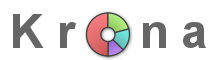


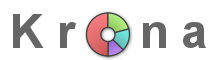

In [11]:
data = extract_data_by_name(metadata, name='Krona summary of LSU taxonomic inventory')
data2 = extract_data_by_name(metadata, name='Krona summary of SSU taxonomic inventory')
r = requests.get(data['downloadUrl']).content.decode('utf-8')
r2 = requests.get(data2['downloadUrl']).content.decode('utf-8')
escaped_content = html.escape(r)
escaped_content2 = html.escape(r2)
iframe = f'<iframe srcdoc="{escaped_content}" style="height:700px; width:1000px;"></iframe>'
# krona1.object = iframe
iframe2 = f'<iframe srcdoc="{escaped_content2}" style="height:700px; width:1000px;"></iframe>'
# krona2.object = iframe2

display(HTML(iframe))
display(HTML(iframe2))
